In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model

from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

np.random.seed(20221107)

In [2]:
# Load the data
path = "../data/weatherAUS.csv"

# Assign format to the date column
data = pd.read_csv(
    path,
    dtype={
        "Location": "category",
        "WindGustDir": "category",
        "WindDir9am": "category",
        "WindDir3pm": "category",
    },
)

# Convert to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Drop the rows with missing values
data = data.dropna(
    axis=0,
    subset=[
        "RainTomorrow",
        "RainToday",
        "Location",
        "WindGustDir",
        "WindDir9am",
        "WindDir3pm",
    ],
)

# Replace Yes and No with 1 and 0
data[["RainToday", "RainTomorrow"]] = data[["RainToday", "RainTomorrow"]].replace(
    "Yes", 1
)
data[["RainToday", "RainTomorrow"]] = data[["RainToday", "RainTomorrow"]].replace(
    "No", 0
)

data["year"] = pd.DatetimeIndex(data["Date"]).year
data["month"] = pd.DatetimeIndex(data["Date"]).month

# For float64 columns, replace the missing values with the month median
name = data.columns
for j in name:
    if data[j].dtypes == "float64":
        fillNA = data.groupby(["year", "month"])[j].transform("median")
        ind = data[j].isna()
        data.loc[data[j].isna(), j] = fillNA[ind]
    elif data[j].dtypes == "category":
        # Get the Dummy Variables for the categorical variables
        dummy = pd.get_dummies(data[j], prefix=j)
        data = pd.concat([data, dummy], axis=1)
        del data[j]

del data["year"]
del data["month"]

x = data.iloc[:, 1:]
del x["RainTomorrow"]

del x["Humidity9am"]

x_columns = x.columns

# Label
y = data["RainTomorrow"]

print(y.value_counts())
print(y.value_counts() / len(y))

ros = RandomUnderSampler(random_state=0)
x, y = ros.fit_resample(x, y)

print(y.value_counts())
print(y.value_counts() / len(y))

# If you want to map the data to (0,1), uncomment the following two lines

Mm = MinMaxScaler()
x = Mm.fit_transform(x)

# If you want to use PCA, uncomment the following two lines
# If you don't use PCA, SVM will consume a long time

# pca = PCA(n_components=0.95)
# x = pca.fit_transform(x)

# print(len(x[0]))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

0    96318
1    27392
Name: RainTomorrow, dtype: int64
0    0.778579
1    0.221421
Name: RainTomorrow, dtype: float64
0    27392
1    27392
Name: RainTomorrow, dtype: int64
0    0.5
1    0.5
Name: RainTomorrow, dtype: float64


In [3]:
font1 = {
    "family": "Times New Roman",
    "weight": "normal",
    "size": 16,
}

Test Accuracy: 0.7965684037601534 
Train Accuracy:  0.7982065849818605


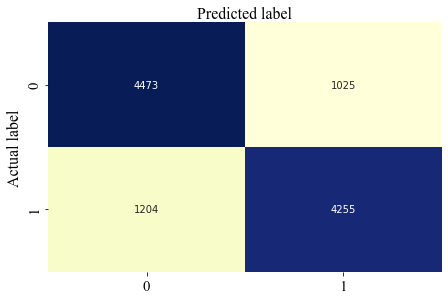

              precision    recall  f1-score   support

 Not Raining       0.79      0.81      0.80      5498
     Raining       0.81      0.78      0.79      5459

    accuracy                           0.80     10957
   macro avg       0.80      0.80      0.80     10957
weighted avg       0.80      0.80      0.80     10957



In [4]:
# Logistic Regression
logreg = LogisticRegression(max_iter=3000)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, logreg.predict(x_train)),
)

# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("Logit_confusion_matrix_undersampling.eps", bbox_inches="tight")

plt.show()

# Classification Report
target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

In [5]:
for i in np.argsort(np.abs(logreg.coef_[0]))[-1:-11:-1]: 
    print(x_columns[i], logreg.coef_[0][i], np.abs(logreg.coef_[0][i]))

Pressure3pm -8.863904122540017 8.863904122540017
WindGustSpeed 7.7723940556909294 7.7723940556909294
Humidity3pm 5.863606960929531 5.863606960929531
Pressure9am 5.311255083992738 5.311255083992738
Rainfall 2.4220439489704604 2.4220439489704604
MaxTemp -2.0023565388651914 2.0023565388651914
WindSpeed3pm -1.9225572595574572 1.9225572595574572
Sunshine -1.7465478612426009 1.7465478612426009
Temp9am 1.4280457441082206 1.4280457441082206
Temp3pm 1.3525325715943848 1.3525325715943848


Test Accuracy: 0.7998539746280916 
Train Accuracy:  0.7987998265909143


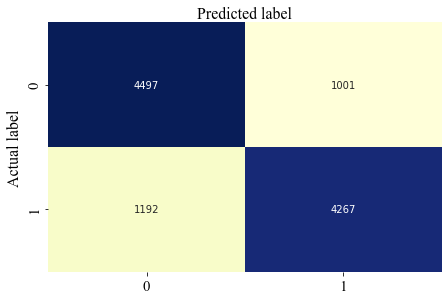

              precision    recall  f1-score   support

 Not Raining       0.79      0.82      0.80      5498
     Raining       0.81      0.78      0.80      5459

    accuracy                           0.80     10957
   macro avg       0.80      0.80      0.80     10957
weighted avg       0.80      0.80      0.80     10957



In [6]:
# SVM
clf = svm.SVC(kernel="linear")

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, clf.predict(x_train)),
)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("SVM_confusion_matrix_undersampling.eps", bbox_inches="tight")

plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.8086154969425938 
Train Accuracy:  0.8468067629543432


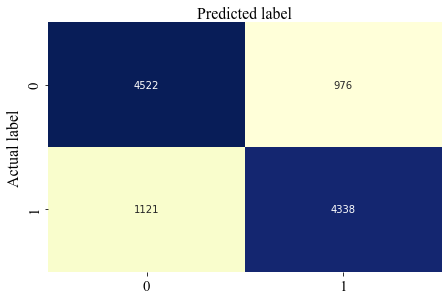

              precision    recall  f1-score   support

 Not Raining       0.80      0.82      0.81      5498
     Raining       0.82      0.79      0.81      5459

    accuracy                           0.81     10957
   macro avg       0.81      0.81      0.81     10957
weighted avg       0.81      0.81      0.81     10957



In [7]:
# SVM with polynomial kernel
clf = svm.SVC(kernel="poly")

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, clf.predict(x_train)),
)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("SVM_poly_confusion_matrix_undersampling.eps", bbox_inches="tight")

plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.8076115725107237 
Train Accuracy:  0.8382732105779542


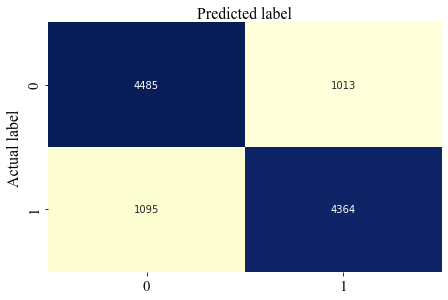

              precision    recall  f1-score   support

 Not Raining       0.80      0.82      0.81      5498
     Raining       0.81      0.80      0.81      5459

    accuracy                           0.81     10957
   macro avg       0.81      0.81      0.81     10957
weighted avg       0.81      0.81      0.81     10957



In [8]:
# SVM with rbf kernel

clf = svm.SVC(kernel="rbf")

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(
    "Test Accuracy:",
    metrics.accuracy_score(y_test, y_pred),
    "\nTrain Accuracy: ",
    metrics.accuracy_score(y_train, clf.predict(x_train)),
)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("SVM_gauss_confusion_matrix_undersampling.eps",
            bbox_inches="tight")

plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

343/343 [==============================] - 1s 2ms/step
Test Accuracy: 0.8062425846490828


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


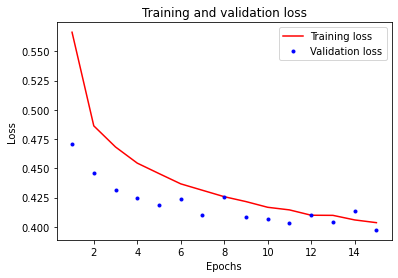

Epoch 1/20
168/168 [==============================] - 2s 10ms/step - loss: 0.5624 - accuracy: 0.7151 - val_loss: 0.4662 - val_accuracy: 0.7980
Epoch 2/20
168/168 [==============================] - 1s 9ms/step - loss: 0.4850 - accuracy: 0.7681 - val_loss: 0.4506 - val_accuracy: 0.7980
Epoch 3/20
168/168 [==============================] - 2s 9ms/step - loss: 0.4685 - accuracy: 0.7788 - val_loss: 0.4323 - val_accuracy: 0.8060
Epoch 4/20
168/168 [==============================] - 1s 9ms/step - loss: 0.4577 - accuracy: 0.7837 - val_loss: 0.4283 - val_accuracy: 0.8060
Epoch 5/20
168/168 [==============================] - 2s 9ms/step - loss: 0.4506 - accuracy: 0.7883 - val_loss: 0.4254 - val_accuracy: 0.8160
Epoch 6/20
168/168 [==============================] - 1s 9ms/step - loss: 0.4425 - accuracy: 0.7949 - val_loss: 0.4181 - val_accuracy: 0.8130
Epoch 7/20
168/168 [==============================] - 1s 9ms/step - loss: 0.4352 - accuracy: 0.7974 - val_loss: 0.4137 - val_accuracy: 0.8160
Epoch

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


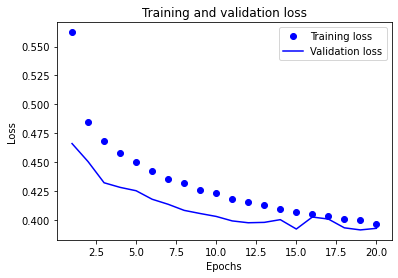

              precision    recall  f1-score   support

 Not Raining       0.82      0.79      0.80      5498
     Raining       0.80      0.83      0.81      5459

    accuracy                           0.81     10957
   macro avg       0.81      0.81      0.81     10957
weighted avg       0.81      0.81      0.81     10957



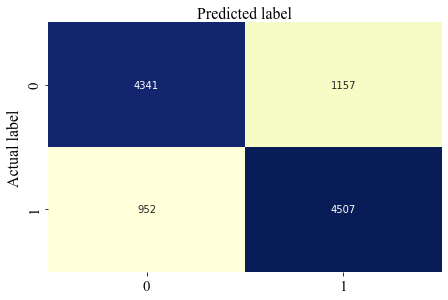

In [9]:
# Split validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train.iloc[:1000]
partial_y_train = y_train.iloc[1000:]

# Build network
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ]

)

# Set optimizer, loss function and metrics
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=50,
    batch_size=256,
    validation_data=(x_val, y_val),
    verbose=0
)

# Calculate accuracy
y_pred_proba = model.predict(x_test)

y_pred = list()

for i in y_pred_proba[:, 0]:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Plot training and validation loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b.", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("error_50.eps", bbox_inches="tight")
plt.show()

# Retrain model with 20 epochs
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=256,
    validation_data=(x_val, y_val),
)

y_pred_proba = model.predict(x_test)

y_pred = list()

for i in y_pred_proba[:, 0]:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("error_20.eps", bbox_inches="tight")
plt.show()

target_names = ["Not Raining", "Raining"]
print(classification_report(y_test, y_pred, target_names=target_names))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual label", font1)
plt.xlabel("Predicted label", font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname("Times New Roman") for label in labels]

plt.savefig("FC_confusion_matrix.eps", bbox_inches="tight")

plt.show()

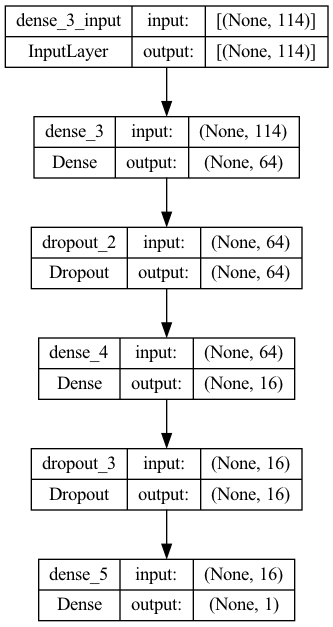

In [10]:
# Plot the Neural Network Structure
plot_model(model, to_file="Network_structure.png", show_shapes=True)